# Multi-Layer Perceptron Neural Network

Welcome to your third assignment. You will build a Multi-Layer Perceptron (MLP) neural network in this assignment. The goal of building such a model is to classify images of wearings.

## Exercises:
1. $\color{violet}{\textbf{(10\%) Data Preprocessing}}$
2. $\color{violet}{\textbf{(5\%) Parameter Initialization}}$
3. $\color{violet}{\textbf{(15\%) Linear Model and Activations}}$
4. $\color{violet}{\textbf{(5\%) Cross Entropy Loss}}$
5. $\color{violet}{\textbf{(30\%) Gradient Computation}}$
6. $\color{violet}{\textbf{(20\%) Gradient Descent Optimization}}$
7. $\color{violet}{\textbf{(15\%) Accuracy Evaluation}}$

## Instructions:
- Write your code only between the $\color{green}{\textbf{\small \#\#\# START CODE HERE \#\#\#}}$ and $\color{green}{\textbf{\small \#\#\# END CODE HERE \#\#\#}}$ commented lines. 
- $\color{red}{\textbf{Change code out of the designated area at your own risk.}}$
- Reference answers are provided after a certain coding blocks. Be aware if your answer is different from the reference..
- **Need to install [Torchvision](https://pytorch.org/vision/stable/index.html)**
    ```console
    pip install torchvision
    ```
**You will learn:**
- One-hot encoding for multi-class targets.
- Rectified Linear Unit (ReLU) activation function.
- Softmax activation.
- Forward and backward propagation of a generic MLP model.



## 1. Load Dataset
Torchvision provides a descent pool of datasets. We'll load one of the built-in dataset, [FashionMNIST](https://pytorch.org/vision/stable/datasets.html) to investigate multi-class classification using a generic Multi-Layer Perceptron (MLP) model.

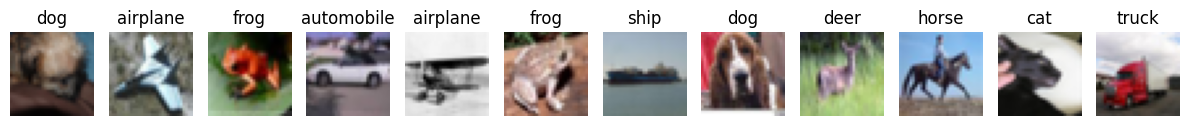

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import Compose, ToImage, ToDtype
import numpy as np
import matplotlib.pyplot as plt

# Construct pre-processing pipeline
feature_transform_pipeline = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    torch.flatten,
    torch.Tensor.numpy,
])
label_transform_pipeline = Compose([
    lambda x:torch.tensor([x]),
    lambda x:torch.nn.functional.one_hot(x,10),
    torch.squeeze,
    torch.Tensor.numpy,
])

# Download datasets
dataset_train = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=feature_transform_pipeline,
    target_transform = label_transform_pipeline,
)

dataset_val = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=feature_transform_pipeline,
)

# Create dataloaders
batch_size = 128
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


# Visualize data samples
sample_batch_train = next(iter(dataloader_train))
fig, axs = plt.subplots(1, 12, figsize=(12, 4))
for i in range(12):
    sample_img = np.transpose(sample_batch_train[0][i].reshape(3, 32, 32), (1, 2, 0))  # reconstruct image to (H, W, C) format
    sample_cls = dataset_train.classes[sample_batch_train[1][i].argmax()]
    axs[i] = plt.subplot(1, 12, i + 1)
    axs[i].set_title(sample_cls)
    axs[i].axis('off')
    axs[i].imshow(sample_img)  # image is already in (H, W, C) format
plt.tight_layout()

In [63]:
print(dataset_train.classes)
print(dataset_val.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
train_set = datasets.FashionMNIST('./data', train=True, download=True)
test_set = datasets.FashionMNIST('./data', train=False, download=True)

# Extract important arrays and information
raw_features_train = train_set.data.numpy()
raw_labels_train = train_set.targets.numpy()
raw_features_test = test_set.data.numpy()
raw_labels_test = test_set.targets.numpy()
category_keys = train_set.classes
category_vals = range(len(category_keys))
category_dict = dict((map(lambda i,j : (i,j), category_keys, category_vals)))

print(f"training features array shape: {raw_features_train.shape}, test features array shape: {raw_features_test.shape}")
print(f"training labels array shape: {raw_labels_train.shape}, test labels array shape: {raw_labels_test.shape}")
print(category_dict)

# Visualize random image and target pair from training dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(train_set))
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(category_keys[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")


## 2. Preprocess the Data
A $\mathcal{C}$-calss dataset is made up with a feature matrix: $\mathbf{X} = [^{(1)}\mathbf{x}, ^{(2)}\mathbf{x}, ..., ^{(M)}\mathbf{x}]^T$. and a one-hot encoded target matrix $\mathbf{Y} = [^{(1)}\mathbf{y}, ^{(2)}\mathbf{y}, ..., ^{(M)}\mathbf{y}]^T$. Where $M$ is the total number of instances in the dataset, $^{(m)}\mathbf{x} = [^{(m)}x_1, ..., ^{(m)}x_n]$ is a normalized and flattened row vector bears $n$ feature values, and $^{(m)}\mathbf{y} = [0, ..., 0, 1, 0, ..., 0]$ is a one-hot encoded row vector.

- A grey-scale image can be represented by a **2-dimensional array with shape $(width, height)$**. Where, $width$ indicates number of pixels on horizontal direction, $height$ indicates number of pixels on vertical direction.
- We can use an **integer ranged 0~255** to describe a pixel's color intensity. However, it is easier for your computer to handlle float values.
- We would like to convert an image array into a row vector, or a **2d array with shape $(1, width*height)$**. So that, we can stack these row vectors on the first dimensions to form a feature matrix.
- We also would like to encode target array into one-hot format.


We will access the raw data by extracting it from the dataloaders. Then, process and prepare the raw data so that it can be used in later steps.

### $\color{violet}{\textbf{(10\%) Exercise 1: Data Preprocessing}}$
1. Reshape feature array.
2. One-hot encode target array
3. Rescale feature arrary to represent each pixel's color intensity value within range: 0~1. 

In [ ]:
### START CODE HERE ### (≈ 8 lines of code)
# Reshape feature and target arrays
reshaped_features_train = None  # (60000, 28, 28) -> (60000, 784)
reshaped_features_test = None  # (10000, 28, 28) -> (10000, 784)
# One hot encode targets
onehot_labels_train = None  # (60000,) -> (60000, 10)
onehot_labels_train[None, None] = None
onehot_labels_test = None  # (10000,) -> (10000, 10)
onehot_labels_test[None, None] = None
# Rescale features
rescale_feature_train = None
rescale_feature_test = None
### END CODE HERE ###

# Rename for later usage
features_train = rescale_feature_train
features_test = rescale_feature_test
labels_train = onehot_labels_train
labels_test = onehot_labels_test
print(f"training features shape: {features_train.shape}, test feature shape: {features_test.shape}, training target shape: {labels_train.shape}, test target shape: {labels_test.shape}")
print(f"sample features slice: \n{features_train[3321:3325, 380:400]}")
print(f"sample labels slice: \n{labels_train[3321:3325]}")


**Expected Output**:
>
```console
training features shape: (60000, 784), test feature shape: (10000, 784), training target shape: (60000, 10), test target shape: (10000, 10)
sample features slice: 
[[0.80392157 0.81176471 0.8        0.80784314 0.83529412 0.83921569
  0.84313725 0.84705882 0.85490196 0.90980392 0.77254902 0.
  0.         0.00784314 0.01960784 0.02745098 0.00784314 0.00392157
  0.         0.        ]
 [0.68235294 0.67843137 0.70196078 0.68627451 0.70980392 0.79607843
  0.65490196 0.68235294 0.76470588 0.20784314 0.         0.
  0.         0.         0.21568627 0.7372549  0.6745098  0.68627451
  0.78039216 0.70196078]
 [0.         0.45882353 0.79607843 0.71372549 0.10980392 0.
  0.38039216 0.45882353 0.38823529 0.38039216 0.45098039 0.08627451
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.37254902 0.4627451  0.25098039 0.17647059 0.2745098  0.21176471
  0.24705882 0.76862745 0.6627451  0.41568627 0.43921569 0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]
sample labels slice: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
```

## 2. Forward Pass
A Multi-Layer Perceptron (MLP) model is featured with multiple layers of transformed features. Any two adjacent layer are connected by a linear model and an activation function. The linear model is governed by a set of weight parameters and a set of bias parameters. The general structure of an MLP model is shown below.

![](./model.png)

### 2.1. Initialize Parameters
A linear model governed by weights $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ transforms features, $\mathbf{X}^{[l-1]}$ to $\mathbf{X}^{[l]}$.

$\mathbf{X}^{[l]} = a (\mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]})$

Where, $\mathbf{X}^{[l-1]}$ has $N_{l-1}$ features and $\mathbf{X}^{[l]}$ has $N_{l}$ features, $\mathbf{W}^{[l]}$ is with shape $(N_l, N_{l-1})$, $\mathbf{b}^{[l]}$ is with shape $(1, N_l)$


In order to get the MLP model prepared, we need to initialize weight matrix and bias vector in every layer.

### $\color{violet}{\textbf{(5\%) Exercise 2: Parameter Initialization}}$
Define a function to initialize weights and biases parameters and save these parameters in a **dictionary**. 
- Input all the layers sizes (**include the input layer**) using a list or tuple.
- Use a **`for` loop** to randomly initialize $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ for transform the features from the $[l-1]$-th layer to the $[l]-th layer$.
- You may find [`np.random.normal()`](https://numpy.org/doc/2.0/reference/random/generated/numpy.random.normal.html) useful when you were trying to create arrays with random numbers.


In [ ]:
def init_params(layer_sizes):
    """ Parameter initialization function
    Args:
        layer_sizes -- list/tuple, (input size, ..., hidden layer size, ..., output size)
    Returns:
        parameters -- dictionary, contains parameters: Wi and bi, i is the i-th layer
    """
    parameters = {}
    ### START CODE HERE ### (≈ 2 lines of code)
    for i in range(len(layer_sizes) - 1):
        parameters['W'+str(i+1)] = None
        parameters['b'+str(i+1)] = None
    ### END CODE HERE ###

    return parameters

# Sanity check
np.random.seed(3321)
dummy_layer_sizes = (6, 5, 4, 3)  # (input size, layer1 size, layer2 size, output size)
dummy_params = init_params(dummy_layer_sizes)
print(dummy_params.keys())
print(dummy_params)


**Expected Output**:
>
```console
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
{'W1': array([[ 3.68455981e-05, -1.38782645e-04, -7.23142013e-05,
         9.20641119e-05, -1.95355264e-05,  3.87255258e-05],
       [-6.00629078e-05,  3.25435259e-06,  6.46665063e-05,
        -7.84748031e-05,  1.41884652e-04, -6.15479349e-05],
       [-1.10127440e-04, -6.82385574e-05,  7.96622349e-05,
         5.25934678e-05, -1.78411966e-04,  1.28629057e-04],
       [ 5.66879246e-05,  8.95999019e-05, -1.62874713e-05,
         3.51109174e-05, -1.03338181e-04, -8.88623865e-05],
       [ 5.10860443e-05,  1.19661547e-04,  8.64757553e-05,
        -1.41101724e-04,  1.38003186e-04, -1.06812125e-04]]), 'b1': array([[ 6.38004843e-05, -6.19666755e-05,  1.12931166e-04,
        -3.12290798e-05,  5.59708416e-05]]), 'W2': array([[ 1.02685210e-04, -1.28307992e-04, -4.03018811e-05,
        -4.09270011e-05, -1.84834135e-05],
       [ 1.71466862e-04, -9.69611346e-05,  4.40873689e-05,
        -1.10516782e-04, -5.17959570e-05],
       [-1.87055902e-04, -6.31341925e-05, -5.47992268e-05,
         3.67804566e-05, -1.05795654e-04],
       [ 1.24964681e-04,  3.60854003e-05,  1.30113815e-04,
         1.01177937e-04,  2.22286230e-05]]), 'b2': array([[ 1.16709537e-04, -1.12496462e-04, -9.47925077e-05,
        -4.49789001e-05]]), 'W3': array([[ 1.01049508e-04, -3.52965408e-05,  2.06672986e-04,
        -1.67359842e-05],
       [-7.34788781e-05,  1.28189925e-05,  3.67334763e-05,
        -3.00482492e-05],
       [ 9.36343566e-05, -3.80351405e-05,  6.59823461e-06,
         5.61206851e-05]]), 'b3': array([[ 2.57409859e-04,  1.69968799e-05, -7.22321090e-05]])}
```

### 2.2 - Forward Propagation
A linear model transforms features, $\mathbf{X}^{[l-1]}$ to $\mathbf{Z}^{[l]}$. Then we apply a non-linear activation function on $\mathbf{Z}^{[l]}$ to form new features $\mathbf{Z}^{[l]}$ in the $l$-th layer.

$\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$

$\mathbf{X}^{[l]} = ReLU(\mathbf{Z}^{[l]}) = 
    \begin{cases}
        0   & z \leq 0 \\
        z   & z > 0
    \end{cases}
$

or,

$\mathbf{X}^{[l]} = \sigma (\mathbf{Z}^{[l]}) = \frac{1}{1 + e^{-\mathbf{Z}^{[l]}}}$

For a multi-class classification problem, it is common to activcate the last layer with a softmax function.

#### $$\hat{y}_i = \frac{e^{z^{[L]}_i}}{\sum^C_{i=1} e^{z^{[L]}_i}}$$

The maxtrix $\mathbf{Z}^{[L]}$ has shape: $(M, C)$, where $M$ is the number of samples, $C$ is the number of classes. When applying softmax activation, we only want to apply it on the 2nd dimension (axis) or perform it on each row in the $\mathbf{Z}^{[L]}$ matrix.

### $\color{violet}{\textbf{(15\%) Exercise 3: Linear Model and Activations}}$
- Define sigmoid function
- Define ReLU function.
- Define softmax function.
- Define linear model.
- Define forward propagation process.


In [ ]:
### START CODE HERE ### (≈ 9 lines of code)
def sigmoid(x):
    """ Sigmoid function
    Args:
        x -- scalar/array
    Returns:
        y -- scalar/array, y = 1 / (1 + e^{-x})
    """
    y = None

    return y

def relu(x):
    """ Rectified linear unit function
    Args:
        x -- scalar/array
    Returns:
        y -- scalar/array, 0 if x <= 0, x if x >0
    """
    y = None

    return y

def softmax(out_features):
    """ Softmax function
    Args:
        out_features: array with shape (M, C)
    Returns:
        probs: array with same shape as arr
    """
    probs = None
    
    return probs

def linear(in_features, weight, bias):
    """ Linear model
    Args:
        in_features (matrix): 2d array with shape (M, N^[l-1])
        weight (matrix): 2d array with shape (N^[l], N^[l-1])
        bias (row vector): 2d array with shape (1, N^[l])
    Returns:
        out_features (matrix): 2d array with shape (M, , N^[l])
    """
    out_features = None
        
    return out_features

def forward(input_features, params, activation='relu'):
    """ Forward propagation process
    Args:
        input_features (matrix): 2d array with shape (M, N^[0])
        params: dictionary, stores W's and b's
        activation: type of the intermediate activation function 
    Returns:
        prediction: 2d array with shape (M, C)
        cache: dictionary, stores intemediate X's and Z's.
    """
    num_layers = int(len(params) / 2)
    cache = {'X0': input_features}
    for i in range(num_layers - 1):
        cache['Z' + str(i+1)] = None
        if activation == 'relu':
            cache['X' + str(i+1)] = None
        elif activation == 'sigmoid':
            cache['X' + str(i+1)] = None
    cache['Z' + str(i+2)] = None
    predictions = None

    return predictions, cache
### END CODE HERE ###

# Sanity check
np.random.seed(3321)
dummy_features = np.random.randn(8,6)
dummy_preds, dummy_cache = forward(dummy_features, dummy_params, activation='relu')
print(dummy_preds)
print(f"cache dictionary keys: {dummy_cache.keys()}")

**Expected Output**:
>
```console
[[0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]]
cache dictionary keys: dict_keys(['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3'])
```

## 3. Multi-Class Cross Entropy Loss
For multi-class classification problem, it is quite standard to use a general form of cross entropy function to evaluate model prediction vs. target. 
#### $\mathcal{L}(\mathbf{\hat{Y}}, \mathbf{Y}) = -\frac{1}{M} \sum_{m=1}^M \sum_{c=1}^C {^{(m)} y_c} \log {^{(m)} \hat{y}_c}$

### $\color{violet}{\textbf{(5\%) Exercise 4: Cross Entropy Loss}}$
Define a cross entropy function to compute the average loss between the prediction array and the groundtruth label array. 


In [ ]:
### START CODE HERE ### (≈ 1 line of code)
def ce_loss(predictions, labels):
    """ Cross entropy loss function
    Args:
        predictions (matrix): 2d array with shape (M, C)
        labels (matrix): 2d array with shape (M, C)
    Returns:
        loss: scalar, averaged ce loss
    """
    loss = None

    return loss
### END CODE HERE ###

# Sanity check
dummy_labels = np.zeros((8, 3))
dummy_labels[np.arange(8), np.random.randint(0, 3, (8,))] = 1
dummy_loss = ce_loss(dummy_preds, dummy_labels)
print(f"CE loss of dummy prediction: {dummy_loss}")

**Expected Output**:
>
```console
CE loss of dummy prediction: 1.098647202419345
```

## 4. Back-Propagation
In order to know how to update weights and biases, we need to compute the gradient of the loss. This requires compute gradient of loss w.r.t. the variables in the last layer first. Then compute gradient of loss w.r.t. the variables in the previous layer next. And so on, until the gradient of loss w.r.t. the first layer is computed. 

Due to the fact that the last layer is softmax activated, $\frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}}$ can be computed differently without explicitly solve for derivative of softmax function.
$$d\mathbf{Z}^{[L]} = \frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}} = \mathbf{\hat{Y}} - \mathbf{Y} $$

Then, from last layer $L$ to first layer, we need to repeatedly computing the gradient of loss according to the chain rule. The computation of a general layer $[l]$ is as follows.
$$d\mathbf{W}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{W}^{[l]}}} = d\mathbf{Z}^{[l]T} \cdot \mathbf{X}^{[l-1]}$$
$$d\mathbf{b}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{b}^{[l]}}} = mean(d\mathbf{Z}^{[l]}, axis=0, keepdims=True)$$
$$d\mathbf{X}^{[l-1]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{X}^{[l-1]}}} = d\mathbf{Z}^{[l]} \cdot \mathbf{W}^{[l]}$$
$$d\mathbf{Z}^{[l-1]} = d\mathbf{X}^{[l-1]} * relu'(\mathbf{Z}^{[l-1]})$$


### $\color{violet}{\textbf{(30\%) Exercise 5: Gradient Computation}}$
- Define the derivative of sigmoid function.
- Define derivative of ReLU function.
- Define a function to perform backward propagation to compute gradient of the (cross entropy) loss

In [ ]:
### START CODE HERE ### (≈ 9 lines of code)
def d_sigmoid(x):
    """ Derivative of sigmoid function
    Args:
        x: scalar/array
    Returns:
        dydx: scalar/array, 0 if x < 0, 1 if x >= 0
    """
    dydx = None

    return dydx

def d_relu(x):
    """ Derivative of ReLU function
    Args:
        x: scalar/array
    Returns:
        dydx: scalar/array, 0 if x < 0, 1 if x >= 0
    """
    dydx = None
    dydx[x < 0] = None

    return dydx

def grad(predictions, labels, params, cache, activation='relu'):
    """ Backward propogating gradient computation
    Args:
        predictions (matrix): 2d array with shape (M, C)
        labels (matrix): 2d array with shape (M, C)
        params: dictionary, stores W's and b's.
        cache: dictionary, stores intemediate X's and Z's.
        activation: string, type of the intermediate activation function.
    Returns:
        grads -- dictionary, stores gradient of the CE loss: dW's and db's
    """
    num_layers = int(len(params) / 2)
    grads = None  # dZ^[L]
    for i in reversed(range(num_layers)):
        grads['dW'+ str(i+1)] = None
        grads['db' + str(i+1)] = None
        if i==0:
            break  
        grads['dX' + str(i)] = None
        if activation == 'relu':
            grads['dZ' + str(i)] = None
        elif activation == 'sigmoid':
            grads['dZ' + str(i)] = None
        else:
            grads['dZ' + str(i)] = grads['dX' + str(i)]

    return grads
### END CODE HERE ###

# Sanity check
dummy_grads = grad(dummy_preds, dummy_labels, dummy_params, dummy_cache)
print(dummy_grads.keys())
print(dummy_grads)

**Expected Output**:
>
```console
dict_keys(['dZ3', 'dW3', 'db3', 'dX2', 'dZ2', 'dW2', 'db2', 'dX1', 'dZ1', 'dW1', 'db1'])
{'dZ3': array([[ 0.33339668, -0.66668347,  0.33328679],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [ 0.33339668,  0.33331653, -0.66671321],
       [ 0.33339668, -0.66668347,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321]]), 'dW3': array([[ 7.79094514e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 7.77672619e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.55676713e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]]), 'db3': array([[ 0.08339668,  0.08331653, -0.16671321]]), 'dX2': array([[ 1.13883818e-04, -3.29905699e-05,  4.66135899e-05,
         3.31572328e-05],
       [-6.06445677e-05,  1.51249634e-05, -1.23325920e-04,
         1.98449678e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
       [ 1.13883818e-04, -3.29905699e-05,  4.66135899e-05,
         3.31572328e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
...
         7.64898491e-10, -2.25124333e-09, -1.93588520e-09],
       [-1.56762876e-09, -3.74956163e-09, -1.11294146e-09,
         8.11358070e-11, -4.79680573e-10,  6.84456641e-11]]), 'db1': array([[-1.36634221e-09,  9.72490113e-10,  4.98906290e-10,
         2.72315047e-10,  3.86057435e-10]])}
```

## 5. Optimization
We have been able to compute the gradient of the cross entropy loss. Now, it's time to perform gradient descent optimization to bring the loss down.

![](./gradient_dscent.png)


### $\color{violet}{\textbf{(20\%) Exercise 6: Gradient Descent Optimization}}$
Train your model. Bring both training loss and test loss down. **Note: you may need to spend more time on this task. So, get started as early as possible.**
1. Customize layer sizes.
2. Use previously created function to complete the training process.
3. Set appropriate iterations and learning rate
4. You can use a `for` loop to update weights and biases embedded in the `params` dictionary.
> Choose the activation function wisely. A poorly activated layer may cause longer training duration as well as poorer model performance.
#### $\color{red}{\text{Bring the \textbf{test} loss down below 0.5}}$


In [ ]:
### START CODE HERE ### (≈ 10 lines of code)
layer_sizes = None
params = None
num_iters = None
learning_rate = None
losses_train, losses_test = [], []
# Optimization loop
for i in range(num_iters):
    preds_train, cache = None
    preds_test, _ = None
    loss_train = None
    loss_test = None
    print(f"Iteration {i+1} training loss: {loss_train}, test loss: {loss_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    grads = None
    for j in range(len(layer_sizes) -1):
        params['W'+str(j+1)] = None
        params['b'+str(j+1)] = None
### END CODE HERE ###

plt.plot(range(num_iters), losses_train, 'b--', range(num_iters), losses_test, 'r')


## 6. Evaluation
Besides cross entropy loss, classification accuracy is another key criteria to evaluate the model.
### $\color{violet}{\textbf{(15\%) Exercise 7: Accuracy Evaluation}}$
- Use [`np.argmax()`](https://numpy.org/doc/2.0/reference/generated/numpy.argmax.html#numpy-argmax) function to find out the index of the biggest number on a specified dimension (axis).
- $\textit{Accuracy} = \frac{\textit{Number of correct predictions}}{\textit{Total number of samples}}$

#### $\color{red}{\text{The \textbf{test} accuracy is expected to be greater than 0.8}}$


In [ ]:
### START CODE HERE ### (≈ 8 lines of code)
# Evaluate with train
pred_classes_train = None  # Get indices of max values in Yhat_train row-wise
is_correct_train = None  # Find out which predictions are correct
num_correct_train = None  # Calculate how many correct predictions are made
accuracy_train = None  # Calculate accuracy rate: correct # / total #
# Evaluate with test
pred_classes_test = None  # # Get indices of max values in Yhat_test row-wise
is_correct_test = None  # Find out which predictions are correct
num_correct_test = None  # Calculate how many correct predictions are made
accuracy_test = None  # Calculate accuracy rate: correct # / total #
### END CODE HERE ###

print(f"prediction accuracy on train set: {accuracy_train}")
print(f"prediction accuracy on test set: {accuracy_test}")

# Compare prediction and target
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(test_set))
    img, label_true = test_set[sample_idx]
    label_pred = pred_classes_test[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"true: {category_keys[label_true]}, pred: {category_keys[label_pred]}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")


## Congrats on finishing this assignment! 